In [1]:
import os
import torch
import numpy as np
import torch.nn as nn
import time
import copy
import shutil

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


#### Pytorch dataloader


In [3]:
!unzip -q '/gdrive/MyDrive/IVP_project/archive.zip'

In [4]:
!ls

brain_tumor_dataset  no  sample_data  yes


In [6]:
from torchvision import datasets ,models,transforms
train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(10),
                                       transforms.RandomAffine(0,shear = 10,scale = (0.8,1.2)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])
                                      ])
train_data = datasets.ImageFolder('brain_tumor_dataset', transform = train_transforms)

In [7]:
generator=torch.Generator().manual_seed(1234)
train_dataset, val_dataset = torch.utils.data.random_split(train_data, [round(train_data.__len__()*0.7),round(train_data.__len__()*0.3)],generator=generator)

In [8]:
train_dataset.__len__(), val_dataset.__len__()

(177, 76)

In [9]:
batch_size = 16
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,shuffle=True)

In [10]:
a,b = next(iter(valid_loader))
print(a.shape,b.shape, a[0].shape)

torch.Size([16, 3, 224, 224]) torch.Size([16]) torch.Size([3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1)


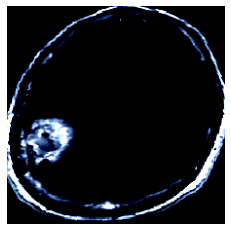

In [11]:
import matplotlib.pyplot as plt
i = 11
plt.imshow(a[i].permute(1,2,0))
plt.axis('off')
print(b[i])

## Pytorch

### GoogleNet builtin

In [12]:
from collections import OrderedDict
import torch.nn as nn

In [13]:
def create_google_net():
  model = torch.hub.load('pytorch/vision:v0.6.0', 'googlenet', init_weights = False)
  # for param in model.parameters():
  #   param.requires_grad = False
  # model.aux_logits = False
  num_ftrs = model.fc.in_features
  classifier = nn.Sequential(OrderedDict([
                            ('fc1', nn.Linear(num_ftrs, 500)),
                            ('relu1', nn.ReLU()),
                            ('dropout1',nn.Dropout(0.7)),
                            ('fc2', nn.Linear(500, 100)),
                            ('relu2', nn.ReLU()),
                            ('dropout2',nn.Dropout(0.2)),
                            ('fc3', nn.Linear(100, 2))
                            ]))
  model.fc = classifier
  model.aux1.fc1 = nn.Sequential(OrderedDict([
                            ('fc1', nn.Linear(model.aux1.fc1.in_features, 100)),
                            ('relu1', nn.ReLU()),
                            ('dropout1',nn.Dropout(0.7))]))
  model.aux1.fc2 = nn.Linear(in_features=100,out_features=2)
  model.aux2.fc1 = nn.Sequential(OrderedDict([
                            ('fc1', nn.Linear(model.aux2.fc1.in_features, 100)),
                            ('relu1', nn.ReLU()),
                            ('dropout1',nn.Dropout(0.7))]))
  model.aux2.fc2 = nn.Linear(in_features=100,out_features=2)

  return model

In [19]:
model = create_google_net()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
from torchsummary import summary
# summary(model,(3,224,224))

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


In [20]:
criterion = nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.0001)

In [17]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()
    print_per_epoch = 1
    if torch.cuda.is_available():
      model.cuda()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    dataloaders = {'train':train_loader, 'val': valid_loader}
    dataset_sizes = {'train': train_loader.dataset.__len__(),'val' : valid_loader.dataset.__len__()}
    softmax = torch.nn.Softmax(dim=1)
    history = {'train_acc':[], 'val_acc':[],'train_loss':[],'val_loss':[]}

    for epoch in range(num_epochs):
        if epoch % print_per_epoch == 0:
          print('Epoch {}/{}'.format(epoch, num_epochs),end = '\t')
        # print('-' * 10,)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
            
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    
                    if phase == 'train':                  
                      out = model(inputs)
                      outputs = out.logits
                      _, preds = torch.max(softmax(outputs),1)
                    # print(labels, outputs,preds)
                      loss1 = criterion(outputs, labels)
                      loss2 = criterion(out.aux_logits1, labels)
                      loss3 = criterion(out.aux_logits2, labels) 
                    # loss = criterion(outputs, labels)
                      loss = loss1 + 0.3*(loss2 + loss3)
                    else:
                      outputs = model(inputs)
                      _, preds = torch.max(softmax(outputs),1)
                      loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                # print(preds)
                running_corrects += torch.sum(preds == labels.data)
                del loss, inputs, labels, outputs
            # if phase == 'train':
                # scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            # print(running_corrects, dataset_sizes[phase])
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            history[phase + '_loss'].append(epoch_loss)
            history[phase + '_acc'].append(epoch_acc)

            if epoch % print_per_epoch == 0:
              print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                  phase, epoch_loss, epoch_acc),end = '\t')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
  
        if epoch % print_per_epoch == 0:
              print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history, best_model_wts,best_acc

In [21]:

model_ft,history,best_model_wts,_ = train_model(model, criterion, optimizer,num_epochs=200)

Epoch 0/200	train Loss: 1.1169 Acc: 0.6158	val Loss: 0.6815 Acc: 0.5789	
Epoch 1/200	train Loss: 1.0661 Acc: 0.6384	val Loss: 0.6818 Acc: 0.5789	
Epoch 2/200	train Loss: 1.0441 Acc: 0.6215	val Loss: 0.6603 Acc: 0.5789	
Epoch 3/200	train Loss: 1.0054 Acc: 0.6441	val Loss: 0.5884 Acc: 0.6711	
Epoch 4/200	train Loss: 0.9188 Acc: 0.6949	val Loss: 0.6447 Acc: 0.6842	
Epoch 5/200	train Loss: 0.9169 Acc: 0.7345	val Loss: 0.5033 Acc: 0.7763	
Epoch 6/200	train Loss: 0.8557 Acc: 0.7627	val Loss: 0.6326 Acc: 0.6974	
Epoch 7/200	train Loss: 0.8697 Acc: 0.7458	val Loss: 0.6190 Acc: 0.6842	
Epoch 8/200	train Loss: 0.7653 Acc: 0.8136	val Loss: 0.6044 Acc: 0.7500	
Epoch 9/200	train Loss: 0.7430 Acc: 0.7797	val Loss: 0.5592 Acc: 0.7632	
Epoch 10/200	train Loss: 0.6612 Acc: 0.8644	val Loss: 0.6507 Acc: 0.6711	
Epoch 11/200	train Loss: 0.6137 Acc: 0.8701	val Loss: 0.6351 Acc: 0.7895	
Epoch 12/200	train Loss: 0.6239 Acc: 0.8814	val Loss: 0.7831 Acc: 0.6447	
Epoch 13/200	train Loss: 0.6116 Acc: 0.8644	val 

In [ ]:
from sklearn.model_selection import KFold
k_folds = 5
batch_size = 32
kfold = KFold(n_splits=k_folds,shuffle = True)
model_wts = {}
results = {}
for fold, (train_ids, test_ids) in enumerate(kfold.split(train_data)):
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
    trainloader = torch.utils.data.DataLoader(
                      train_data, 
                      batch_size=batch_size, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
                      train_data,
                      batch_size=batch_size, sampler=test_subsampler)
    model = create_google_net()
    criterion = nn.CrossEntropyLoss()
    optimizer=torch.optim.Adam(model.parameters(),lr=1e-4)

    model_ft,history,best_model_wts, best_acc = train_model(model, criterion, optimizer,num_epochs=50)

    print('Accuracy for fold %d: %f %%' % (fold, best_acc))
    print('--------------------------------')
    results[fold] = best_acc
    model_wts[fold] = best_model_wts 
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------\n')
sum = 0.0
for key, value in results.items():
  print(f'Fold {key}: {value} %')
  sum += value
print(f'Average: {sum/len(results.items())} %')

In [ ]:
results = {0:100,1:100,2:99}
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')
sum = 0.0
for key, value in results.items():
  print(f'Fold {key}: {value} %')
  sum += value
print(f'Average: {sum/len(results.items())} %')

K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Fold 0: 100 %
Fold 1: 100 %
Fold 2: 99 %
Average: 99.66666666666667 %


In [ ]:
torch.save(best_model_wts,'/gdrive/MyDrive/IVP_project/GoogLeNet/GoogleNet_newdata_weights.pt')

In [ ]:
model.load_state_dict(torch.load('/gdrive/MyDrive/IVP_project/GoogLeNet/GoogleNet_newdata_weights.pt'))

<All keys matched successfully>

In [ ]:
history1 = history

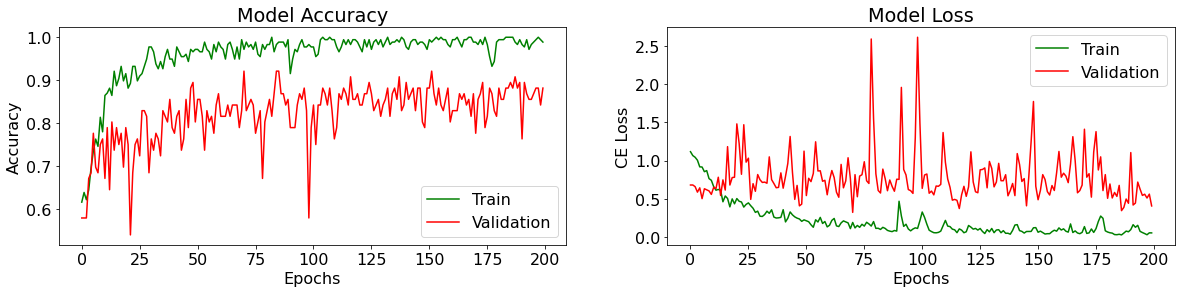

In [22]:
import matplotlib.pyplot as plt

root = '/gdrive/MyDrive/IVP_project/GoogLeNet/'
num_epochs = range(len(history['train_loss']))
plt.rcParams['font.size'] = 16
figure, axs = plt.subplots(1,2, figsize = (20,4))

axs[0].plot(num_epochs,history['train_acc'],'g')
axs[0].plot(num_epochs,history['val_acc'],'r')
axs[0].legend(['Train', 'Validation'])
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Accuracy")
axs[0].set_title("Model Accuracy")
# axs[1].savefig(root + 'GoogLeNet_Accuracy.png',tight_layout = True)

axs[1].plot(num_epochs,history['train_loss'],'g')
axs[1].plot(num_epochs,history['val_loss'],'r')
axs[1].legend(['Train', 'Validation'])
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("CE Loss")
axs[1].set_title("Model Loss")
# axs.savefig(root + 'GoogLeNet_Loss.png',tight_layout = True)
plt.show()